In [73]:
import scanpy.api as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from scipy import stats
import numpy as np

%matplotlib inline

sns.set(style='whitegrid', palette='Set3', font_scale=1.3)

In [2]:
data = pd.read_csv('./pbmc3k_data.csv', index_col=0).T
tsne = pd.read_csv('./pbmc3k_metadata.csv', index_col=0)

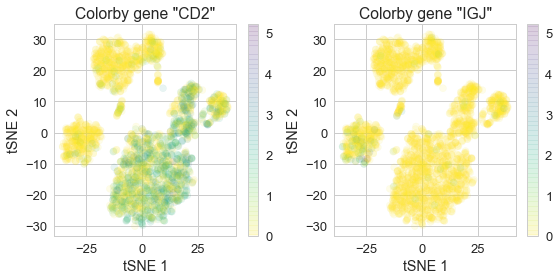

In [3]:
cmap = cm.viridis_r
fig, (tcr_ax, bcr_ax) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

colorby_tcr_norm = colors.Normalize(vmin=0,vmax=data['CD2'].max())
tcr_vals = tcr_ax.scatter(tsne['tSNE_1'], tsne['tSNE_2'], c=data['CD2'].values, 
           cmap=cmap, norm=colorby_tcr_norm, alpha=0.1)
fig.colorbar(tcr_vals, ax=tcr_ax)
tcr_ax.set_title('Colorby gene "CD2"')
tcr_ax.set_xlabel('tSNE 1')
tcr_ax.set_ylabel('tSNE 2')

colorby_bcr_norm = colors.Normalize(vmin=0,vmax=data['IGJ'].max())
bcr_vals = bcr_ax.scatter(tsne['tSNE_1'], tsne['tSNE_2'], c=data['IGJ'].values, 
           cmap=cmap, norm=colorby_bcr_norm, alpha=0.1)
fig.colorbar(tcr_vals, ax=bcr_ax)
bcr_ax.set_title('Colorby gene "IGJ"')
bcr_ax.set_xlabel('tSNE 1')
bcr_ax.set_ylabel('tSNE 2')

plt.tight_layout()
plt.show()

## Colorby gene 'CD2'  
### Context: CD2 is a T-cell receptor. IGJ is a B-cell receptor. They should be expressed strongly in distinct populations of cells.

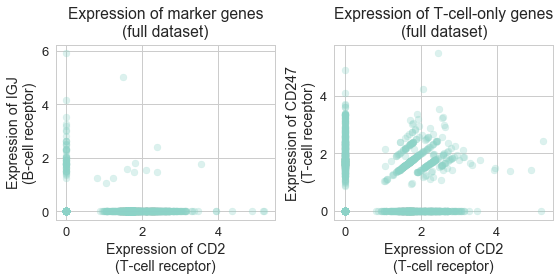

In [4]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.sca(ax0)
plt.scatter(data['CD2'], data['IGJ'], alpha=0.3)
ax0.set_xlabel('Expression of CD2\n(T-cell receptor)')
ax0.set_ylabel('Expression of IGJ\n(B-cell receptor)')
ax0.set_title('Expression of marker genes\n(full dataset)', va='bottom')

plt.sca(ax1)
plt.scatter(data['CD2'], data['CD247'], alpha=0.3)
ax1.set_xlabel('Expression of CD2\n(T-cell receptor)')
ax1.set_ylabel('Expression of CD247\n(T-cell receptor)')
ax1.set_title('Expression of T-cell-only genes\n(full dataset)', va='bottom')



plt.tight_layout()

## Gene expression scatterplot 
### Context:   
#### [Left] CD2 is a T-cell receptor. It should only really be in T-cells. IGJ helps make antibodies, it should really only be in B-cells.  
#### [Right] CD2 and CD247 are both related to T-cell receptors. When expressed, they should be fairly well correlated.

Text(0.5,0,'Proportion of cells expressing')

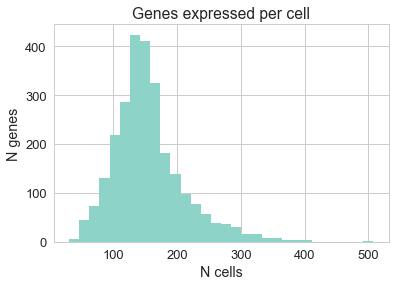

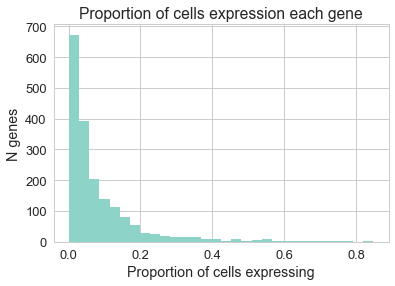

In [5]:
nonzero = data.mask(data.values > 0, other=1)
genes_per_cell = nonzero.sum(axis=1)
# print(genes_per_cell.head())
fig, ax = plt.subplots()
plt.hist(genes_per_cell.values, bins=30)
ax.set_title('Genes expressed per cell')
ax.set_xlabel('N cells')
ax.set_ylabel('N genes')


pCells_per_gene = nonzero.sum(axis=0)/len(nonzero.index.values)
fig, ax = plt.subplots()
plt.hist(pCells_per_gene.values, bins=30)
ax.set_title('Proportion of cells expression each gene')
ax.set_ylabel('N genes')
ax.set_xlabel('Proportion of cells expressing')

In [6]:
### Define clusters 
adata = sc.read('./pbmc3k_data.csv').T
sc.pp.pca(adata, n_comps=len(adata.X))
sc.pp.neighbors(adata, metric='euclidean', random_state=2018)
sc.tl.louvain(adata, random_state=2018)
data['cluster'] = adata.obs['louvain']
tsne['cluster'] = data['cluster']

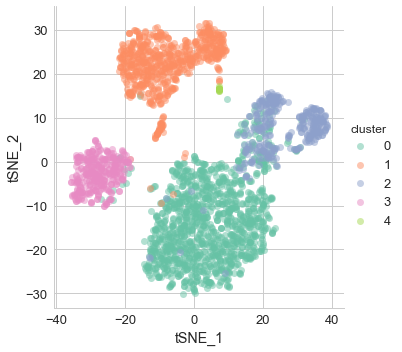

In [16]:
sns.lmplot('tSNE_1','tSNE_2', tsne,hue='cluster', fit_reg=False, palette='Set2', scatter_kws={'alpha':0.5})

In [82]:
''' From Charlotte\'s cellxgene-rest-api code: '''


def diffexp(expression_1, expression_2, pval=0.001, num_genes=20):
    """
    get top expressed genes from two different cell sets (uses t-test)
    :param expression_1: numpy expression array cell set 1
    :param expression_2: numpy expression array cell set 2
    :param pval: stats limit
    :param num_genes: number of genes to limit results to
    :return: Top genes and mean expression, pvalue, and average difference
     between cell set1 to cell set 2 for each gene in both cell sets
     sorted by t-test value
    """

    genes = expression_1.columns.values
    assert list(genes) == list(expression_2.columns.values)
    
    expression_1, expression_2 = expression_1.values, expression_2.values
    diff_exp = stats.ttest_ind(expression_1, expression_2)
    set1 = np.logical_and(diff_exp.pvalue < pval, diff_exp.statistic > 0)
    set2 = np.logical_and(diff_exp.pvalue < pval, diff_exp.statistic < 0)
    stat1 = diff_exp.statistic[set1]
    stat2 = diff_exp.statistic[set2]
    sort_set1 = np.argsort(stat1)[::-1]
    sort_set2 = np.argsort(stat2)
    pval1 = diff_exp.pvalue[set1][sort_set1]
    pval2 = diff_exp.pvalue[set2][sort_set2]
    mean_ex1_set1 = np.mean(expression_1[:, set1], axis=0)[sort_set1]
    mean_ex2_set1 = np.mean(expression_2[:, set1], axis=0)[sort_set1]
    mean_ex1_set2 = np.mean(expression_1[:, set2], axis=0)[sort_set2]
    mean_ex2_set2 = np.mean(expression_2[:, set2], axis=0)[sort_set2]
    mean_diff1 = mean_ex1_set1 - mean_ex2_set1
    mean_diff2 = mean_ex1_set2 - mean_ex2_set2
    genes_cellset_1 = np.array([genes[idx] for idx, val in enumerate(set1) if val])[sort_set1]
    genes_cellset_2 = np.array([genes[idx] for idx, val in enumerate(set2) if val])[sort_set2]
    return {
        "celllist1": {
            "topgenes": genes_cellset_1.tolist()[:num_genes],
            "mean_expression_cellset1": mean_ex1_set1.tolist()[:num_genes],
            "mean_expression_cellset2": mean_ex2_set1.tolist()[:num_genes],
            "pval": pval1.tolist()[:num_genes],
            "ave_diff": mean_diff1.tolist()[:num_genes]
        },
        "celllist2": {
            "topgenes": genes_cellset_2.tolist()[:num_genes],
            "mean_expression_cellset1": mean_ex1_set2.tolist()[:num_genes],
            "mean_expression_cellset2": mean_ex2_set2.tolist()[:num_genes],
            "pval": pval2.tolist()[:num_genes],
            "ave_diff": mean_diff2.tolist()[:num_genes]
        },
    }



In [104]:
pink_cluster = data.loc[data['cluster'] == '3'].loc[:, data.columns != 'cluster'].astype(float)
orange_cluster = data.loc[data['cluster'] == '1'].loc[:, data.columns != 'cluster'].astype(float)

de = diffexp(pink_cluster, orange_cluster, num_genes = 5)
de = pd.DataFrame(de['celllist1']).append(pd.DataFrame(de['celllist2']))
de = de.set_index('topgenes')
de = de.sort_values('mean_expression_cellset2')

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Text(4,0.5,'')

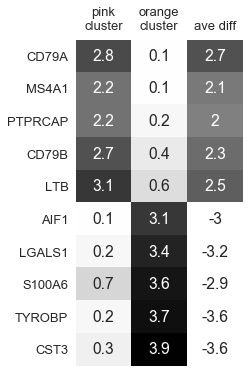

In [128]:
expression_vals = de[['mean_expression_cellset1', 'mean_expression_cellset2']]
vmin = expression_vals.min().min()
vmax = expression_vals.max().max()
fig, ax = plt.subplots(figsize=(3,6))
sns.heatmap(de[['mean_expression_cellset1', 'mean_expression_cellset2', 'ave_diff']].round(1), 
            cmap='gray_r', ax=ax, annot=True, cbar=False, linewidths=0, vmin=vmin, vmax=vmax)
ax.set_xticklabels(['pink\ncluster', 'orange\ncluster', 'ave diff'])
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_ylabel('')

## Differential expression sanity check  
#### The exact clusters I used are shown above.  They correspond closely to "pink cluster ~= EM2 cluster 2" and "orange cluster ~= EM2 cluster 1", but they exact cells may vary slightly. Thus, the genes and exact values may vary slightly from what's shown above, but they should be very close.